Revised/simplified version of the `sunspots.ipynb` notebook.

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import astropy.units as u

import sys
sys.path.insert(0, '../')
from mrspoc import Star, Spot

spot_table = ascii.read('Mt_Wilson_Tilt/mwo_spot_table.txt').group_by('jd')
spot_table.add_index('jd')

Example, demo of API:

../mrspoc/star.py:379: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1 - r**2)


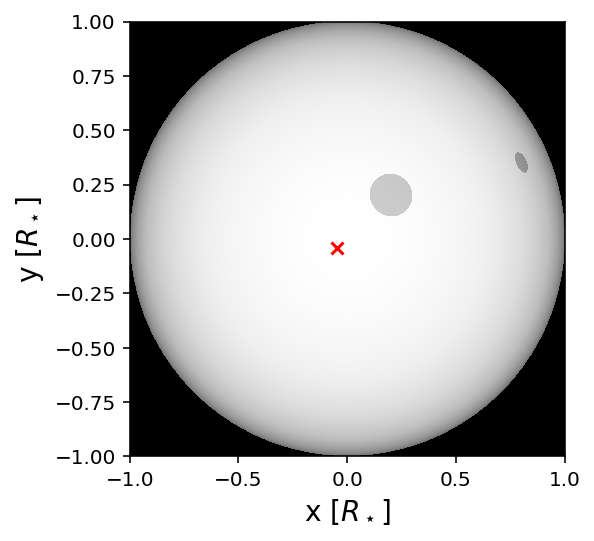

In [2]:
s = Star()
stellar_inclination = 90
spot_list = [Spot(x=0.2, y=0.20, r=0.10),
             Spot(x=0.8, y=0.35, r=0.05)]

s.spots.extend(spot_list)

ax = s.plot(col_exaggerate=50)

For all dates in the MWO spot catalog, compute the solar photocenter. 

In [3]:
dates = sorted(list(set(spot_table['jd'])))
center_of_light = []

scale_up_umbra = 5

with ProgressBar(len(dates), ipython_widget=True) as bar:
    for date in dates:    
        sun = Star()
        spots_today = spot_table[spot_table['jd'] == date]

        for spot in spots_today:
            lon = spot['area_weighted_longitude_day_1']
            lat = spot['area_weighted_latitude_day_1']
            areas = spot['area_day_1']
            rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
            new_spot = Spot.from_latlon(lat, lon, stellar_inclination, rspot_rstar)
            sun.spots.append(new_spot)

        center_of_light.append(sun.center_of_light)
        bar.update()

center_of_light = np.array(center_of_light)

FloatProgress(value=0.0)

Plot the stellar photocenter for all dates:

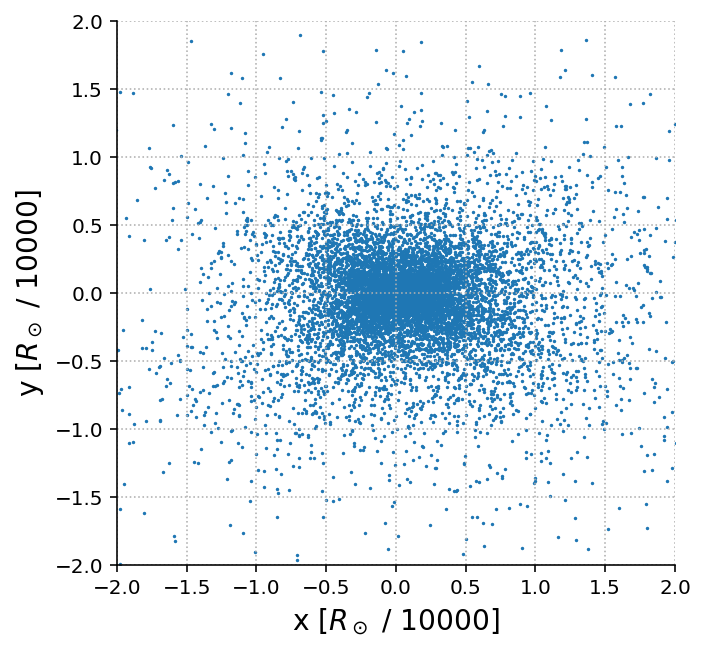

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(center_of_light[:, 0] * 10000, center_of_light[:, 1] * 10000, marker='.', s=2)
ax.set_xlabel('x [$R_\odot$ / 10000]', fontsize=14)
ax.set_ylabel('y [$R_\odot$ / 10000]', fontsize=14)
ax.set(xlim=[-2, 2], ylim=[-2, 2])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(ls=':')
# fig.savefig('plots/photocenter_motion.pdf', bbox_inches='tight')

What is the median absolute deviation of the solar photocenter over the entire MWO sample?

In [5]:
from astropy.stats import mad_std, median_absolute_deviation

mad = lambda x: mad_std(x)/1.4826

for mad in [lambda x: mad_std(x)/1.4826, median_absolute_deviation]:
    not_nan = ~np.any(np.isnan(center_of_light), axis=1)
    mad_x = mad(center_of_light[not_nan, 0])
    mad_y = mad(center_of_light[not_nan, 1])

    print("MAD x = {0}\nMAD y = {1}".format(mad_x, mad_y))

MAD x = 2.4593520766300203e-05
MAD y = 1.5896624991907886e-05
MAD x = 2.4593483965556944e-05
MAD y = 1.5896601204845407e-05


Compute the sizes 

In [6]:
spot_radii = np.sqrt(1e-6 * 10 * spot_table['area_day_1'])

Compute the displacement vector of the solar photocenter from the true solar centroid at each time.

//anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "d2dtf" yielded 6899 of "dubious year (Note 5)"
  ErfaWarning)
//anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 6899 of "dubious year (Note 6)"
  ErfaWarning)
//anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 6640 of "dubious year (Note 6)"
  ErfaWarning)


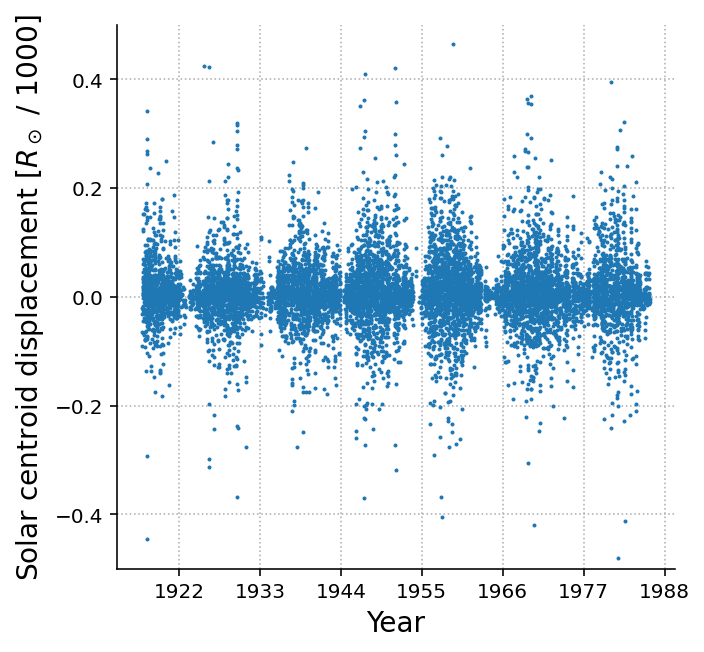

In [7]:
from astropy.time import Time

r_vector = center_of_light[:, 0]
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(Time(dates, format='jd').decimalyear, 1000 * r_vector, '.', markersize=2)

ax.set_xticks(np.arange(1922, 1990, 11))
ax.set(ylim=[-0.5, 0.5])
ax.set_xlabel('Year', fontsize=14) 
ax.set_ylabel('Solar centroid displacement [$R_\odot$ / 1000]', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.grid(ls=':')
# fig.savefig('plots/solar_centroid_displacement.pdf', bbox_inches='tight')

What are the typical and most extreme centroid shifts in the x direction?

In [12]:
max_centroid_shift = np.nanmax(center_of_light[:, 0])
print('max_x = {}'.format(((max_centroid_shift * u.R_sun).to(u.uAU))))

std_centroid_shift = np.std(center_of_light[:, 0])
print('std_x = {}'.format(((std_centroid_shift * u.R_sun).to(u.uAU))))

max_x = 3.328747790129977 uAU
std_x = 0.2915067583064418 uAU
